In [11]:
import xarray as xr
from pathlib import Path
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

# Data wrangling

### Import data

In [12]:
# data directories
path = Path('/home/links/ct715/data_storage/isca/held-suarez')
exp_list = ['HS_T21_100y-nc', 'HS_T42_100y-nc', 'HS_T85_100y-nc']

datasets = {}
for exp in exp_list:
    
    # save path
    save_path = path / 'wrangled'
    save_path.mkdir(parents=True, exist_ok=True)
    save_data = save_path / f'{exp}_annual-mean.nc'
    
    if save_data.exists():
        print(f'File {save_data} already exists, skipping...')
        # Import annual mean data
        ds = xr.open_dataset(save_data)
        datasets[exp] = ds
    else:
        nc_path = Path(path) / exp
        nc_files = list(nc_path.glob('*.nc'))
        
        ds = xr.open_mfdataset(
            nc_files,
            parallel=True,
            chunks={'time': 360}
        )

        ds_annual_mean = ds.mean('time')
        ds_annual_mean.to_netcdf(save_data)

File /home/links/ct715/data_storage/isca/held-suarez/wrangled/HS_T21_100y-nc_annual-mean.nc already exists, skipping...
File /home/links/ct715/data_storage/isca/held-suarez/wrangled/HS_T42_100y-nc_annual-mean.nc already exists, skipping...
File /home/links/ct715/data_storage/isca/held-suarez/wrangled/HS_T85_100y-nc_annual-mean.nc already exists, skipping...


In [16]:
datasets

{'HS_T21_100y-nc': <xarray.Dataset> Size: 1MB
 Dimensions:  (level: 40, lat: 32, lon: 64)
 Coordinates:
   * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
   * lat      (lat) float64 256B -85.76 -80.27 -74.74 ... 74.74 80.27 85.76
   * level    (level) float32 160B 987.0 962.0 937.0 912.0 ... 87.0 62.0 37.0 9.0
 Data variables:
     u        (level, lat, lon) float32 328kB ...
     v        (level, lat, lon) float32 328kB ...
     t        (level, lat, lon) float32 328kB ...
     ubar     (level, lat) float32 5kB ...
     epfy     (level, lat) float32 5kB ...
     epfz     (level, lat) float64 10kB ...
     divFy    (level, lat) float64 10kB ...
     divFz    (level, lat) float64 10kB ...,
 'HS_T42_100y-nc': <xarray.Dataset> Size: 4MB
 Dimensions:  (level: 40, lat: 64, lon: 128)
 Coordinates:
   * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
   * lat      (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
   * le

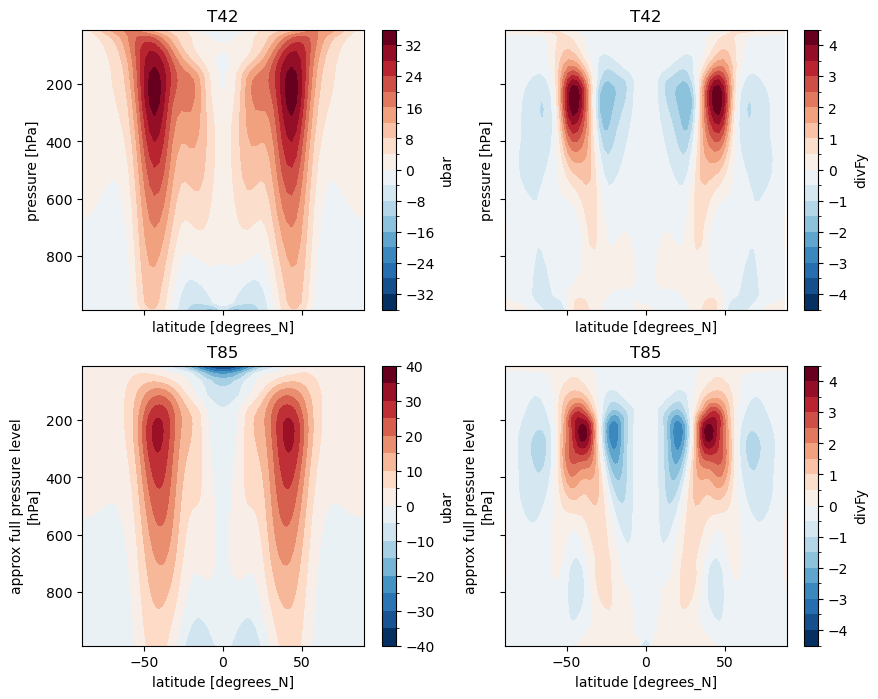

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharey=True, sharex=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

datasets['HS_T42_100y-nc'].ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,0])
datasets['HS_T42_100y-nc'].divFy.plot.contourf(levels=20, yincrease=False, ax=axes[0,1])

datasets['HS_T85_100y-nc'].ubar.plot.contourf(levels=20, yincrease=False, ax=axes[1,0])
datasets['HS_T85_100y-nc'].divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1,1])

for ax in axes[0,:]:
    ax.set_title('T42')
for ax in axes[1,:]:
    ax.set_title('T85')

### Subsetting and calculations

In [18]:
# calculate EFP for each experiment and save to dictionary
efp_values = {}
for exp in exp_list:
    
    # calculate EFP
    efp_NH = ef.calculate_efp(datasets[exp], data_type='isca')
    efp_SH = ef.calculate_efp(datasets[exp], data_type='isca', calc_south_hemis=True)
    
    # save value into a dict of dictionaries 
    efp_values[exp] = {
        'NH': efp_NH,
        'SH': efp_SH
    }
efp_values

KeyError: "No variable named 'time'. Variables on the dataset include ['u', 'v', 't', 'lon', 'lat', ..., 'ubar', 'epfy', 'epfz', 'divFy', 'divFz']"

In [ ]:
# calculate djf seasonal mean
exps_djf = {}
exps_jas = {}
for exp in exp_list:
    
    # calc seasonal mean for each dataset
    djf_mean = data.seasonal_mean(datasets[exp], season='djf')
    # save to dict
    exps_djf[exp] = djf_mean
    
    # calc seasonal mean for each dataset
    jas_mean = data.seasonal_mean(datasets[exp], season='jas')
    # save to dict
    exps_jas[exp] = jas_mean

### Annual differences

In [ ]:
datasets['HS_T85_100y-nc'] = datasets['HS_T85_100y-nc'].interp(lat=datasets['HS_T42_100y-nc'].lat.values)
datasets['HS_T85_100y-nc'] = datasets['HS_T85_100y-nc'].interp(lat=datasets['HS_T42_100y-nc'].level.values)

diff = datasets['HS_T85_100y-nc'].mean('time') - datasets['HS_T42_100y-nc'].mean('time')

# # subset data
diff = diff.sel(lat=slice(-85,85))
diff = diff.sel(level=slice(925., 100.))

In [ ]:
diff

<xarray.Dataset>
Dimensions:  (lon: 128, level: 0, lat: 0)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * level    (level) float64 
  * lat      (lat) float64 
Data variables:
    u        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    v        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    t        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    ubar     (level, lat) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    epfy     (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    epfz     (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    divFy    (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    divFz    (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>

TypeError: No numeric data to plot.

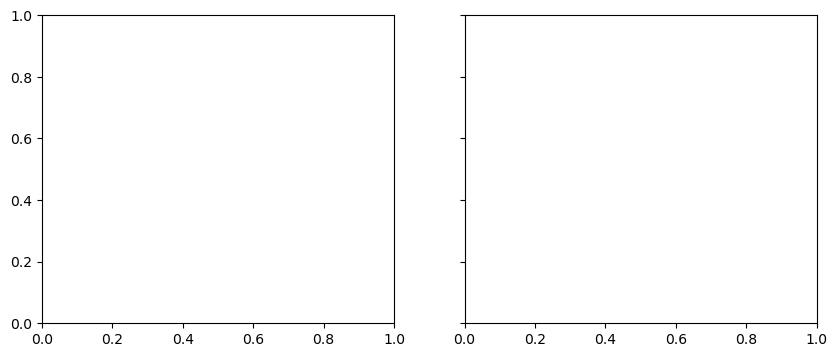

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

diff.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0])
diff.divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1])

# set titles
axes[0].set_title(f'', fontsize=16)
axes[1].set_title('')

# set axes titles
axes[0].set_xlabel('')

# plot rectangle
# Define rectangles and add them to each subplot
for ax in axes[:]:
    rect = patches.Rectangle((-75, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
for ax in axes[:]:
    rect = patches.Rectangle((25, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
    

fig.suptitle('Difference plot (T85 - T42)', fontsize=20)

plt.show()